# 9장 암과 싸워 이기기 위한 파이토치 활용


## 대규모 프로젝트 준비

이번 장부터는 CT 스캔 데이터로 학습을 해볼 것이다. CT 스캔 이미지를 통해 종양이나 암의 징후를 찾는 모델을 만들어 볼것이다. CT 스캔 데이터는 구하기 x-ray랑 다르게 구하기 어렵고, 학습을 하는데 필요한 시간도 굉장히 많이 든다. 그러므로 모델을 만드는데 집중하는 것이 아니라 프로젝트가 어떻게 진행될지 집중하고, 데이터를 우리가 사용할 수 있는 형태로 변환하는 작업에 집중해볼 것이다.

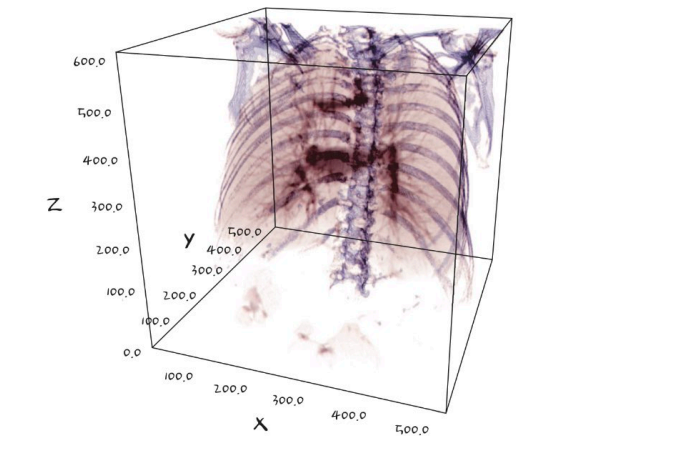

위 그림과 같이 데이터를 3차원으로 랜더링하고 뼈와 폐 조직만 보이게 할 수 있다. 아래 그림과 같이 CT 기계를 통과하며 3차원의 데이터를 얻을 수 있다

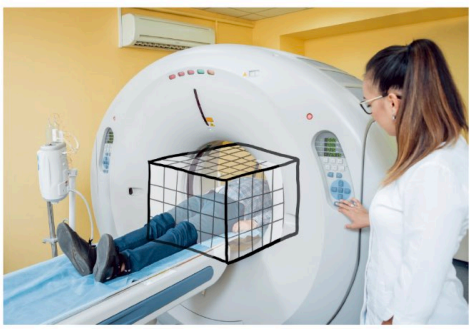

## 프로젝트: 엔드투엔드 폐암 진단기

프로젝트의 엔드투엔드 솔루션을 한번 확인해보자

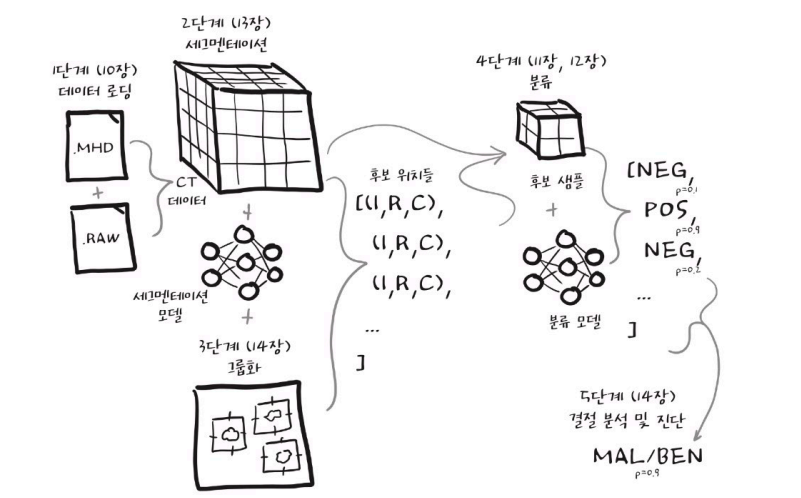

먼저 CT 데이터 파일을 읽어서 CT 인스턴스를 만들고 전체 3차원 스캔 데이터를 담고 세그맨테이션을 수행하는 모듈과 결합한다. 세그맨테이션은 관심 있는 복셀을 표시하는 과정이다. 이후 추려진 복셀을 작은 덩어리로 나누어 결절로 간주될만한 것을 찾는다

이러한 결절 위치 정보는 복셀 데이터 뒤에 붙어 일종의 후보가 되고 이 후보들은 결절로 분류되는 모델에 의해 애초부터 실제 결절인지, 그리고 최종적으로 악성이 될지 여부를 조사하게 된다.

구체적으로 할 작업은 다음과 같다
1. 원본 CT 스캔 데이터를 파이토치로 사용할 수 있는 형태로 읽어들인다
2. 세그멘테이션이라는 기술 구현을 위해 파이토치를 사용하여 폐의 잠재적 결절에 해당하는 복셀을 찾는다. 이 작업으로 관심 없는 해부학적 부위(폐암이 위에 발생할 수 없으므로 위에는 관심이 없다)는 무시하고 폐 내부의 잠재적 종양에 집중할 수 있다.
3. 관심 있는 복셀들을 덩어리로 묶는다.
4. 3차원 컨볼루션을 사용하여 각 후보 결절에 대해 실제 결절인지 아닌지 분류한다. 이는 2차원 컨볼루션 개념과 흡사하다.
5. 각 결절별로 분류한 결과를 종합하여 환자를 진단한다.

4단계에서는 이미 전문의들에 의해 사람이 확인하고 표기한 정답을 제공한다. 이 과정은 2, 3단계와는 완전히 별개이기 때문에, 우리는 4단계를 먼저 실행하여 학습을 한 후 다시 2단계와 3단계로 돌아와 구현할 예정이다. 

이처럼 프로젝트를 위하여 단순히 모델만을 만드는 것이 아니라, 데이터나 문제 도메인에 대한 조사가 이루어져야 한다. 데이터 타입이 동일하더라도 데이터가 다루는 영역은 다르기 때문에 전혀 다르게 진행해야 할 수도 있다. 

토치 비전에서는 Fast R-CNN이나 Mask R-CNN과 같은 모델이 포함되어 있지만, 이러한 모델은 전형적으로 수십만건의 이미지로 훈련되었으며, 이때 데이터셋은 제한된 수량의 샘플을 가지는 특이한 클래스인 경우도 아니다. 이러한 모델에 우리가 원하는 결과를 얻을 때까지 임의의 많은 데이터를 집어넣는 것은 이론적으로 가능하나, 적당하게 훈련되도록 기다려야 하는 시간과 수집해야 하는 데이터 양은 실용적이지 않다. 

먼저 결절에 대한 정의를 알아야 한다. 결절이란 누군가의 폐 내부에 나타날 수 있는 무수한 돌기나 덩어리를 말한다. 이러한 결절은 환자 건강에 문제가 되는 것도 있고 안되는 것도 있다. 핵심은 우리가 찾아내려는 암은 항상 결절의 형태를 띄며, 이 결절은 밀도가 매우 낮은 폐 조직에 매달려 있거나 폐 벽에 붙어 있을 것이라는 점이다. 

## 데이터 소스: LUNA 그랜드 챌린지

우리가 사용하는 CT 스캔은 LUNA 그랜드 챌린지에서 가져온 것이다. LUNA 그랜드 챌린지는 환자의 CT 스캔 자료를 고품질로 레이블 작업한 공개 데이터셋으로서 데이터 분류기 성능에 대한 공개 랭킹을 제공한다. 


https://luna16.grand-challenge.org/Download/

위 사이트로 이동하여 데이터셋을 다운받았다. 총 용량이 120GB 정도 되어 충분한 공간이 있어야 할 것이다. 이 외에도 candidates.csv와 annotations.csv 파일도 필요하다.

이번 장에서는 두 가지를 살펴보았다
1. 폐암 진단 프로젝트를 큰 맥락에서 이해해봄
2. 2부 학습을 위한 프로젝트의 방향과 구조에 대한 개요 파악
실제로 코드를 작성하고 진전이 없었다고 느낄 수 있지만, 그것은 큰 함정이다. 프로젝트가 동작하는 전문 영역에 대한 이해를 높이는 것은 매우 중요하다.